In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flowers-recognition/flowers/dandelion/34578947551_863af3acb3_n.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/2625836599_03e192266f.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/16242239484_51286673af.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/5716633491_55e6f02645_n.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/34697163155_5dc2571f23_n.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/34686041416_e50c8028f9_n.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/8719032054_9a3ce4f0ff.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/9472854850_fc9e1db673.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/31530587330_ba31bd196e_n.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/9293460423_7fbb1e3c32_n.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/9939430464_5f5861ebab.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/2535769822_513be6bbe9.jpg
/kaggle/input/flowers-recognition/flowers/dande

**Data Loading & Preprocessing**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16  # or ResNet, MobileNet, etc.
from sklearn.model_selection import train_test_split
import os


In [3]:
import os

# Path to the flowers dataset on Kaggle
dataset_path = '/kaggle/input/flowers-recognition/flowers'

# Let's check how the dataset is structured
print(os.listdir(dataset_path))


['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']


In [4]:
# Define the image size and batch size
IMG_SIZE = (224, 224)  # Resize all images to this size to match VGG16 input size
BATCH_SIZE = 32

# ImageDataGenerator for data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalize pixel values (from 0-255 to 0-1)
    validation_split=0.2,   # Split 20% of the data for validation
    horizontal_flip=True,   # Randomly flip some images
    rotation_range=30,      # Random rotation
    zoom_range=0.2          # Random zoom
)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',    # Multiclass classification
    subset='training'            # Only use the training set
)

# Validation data generator
validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',    # Multiclass classification
    subset='validation'          # Use the validation set
)


Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.


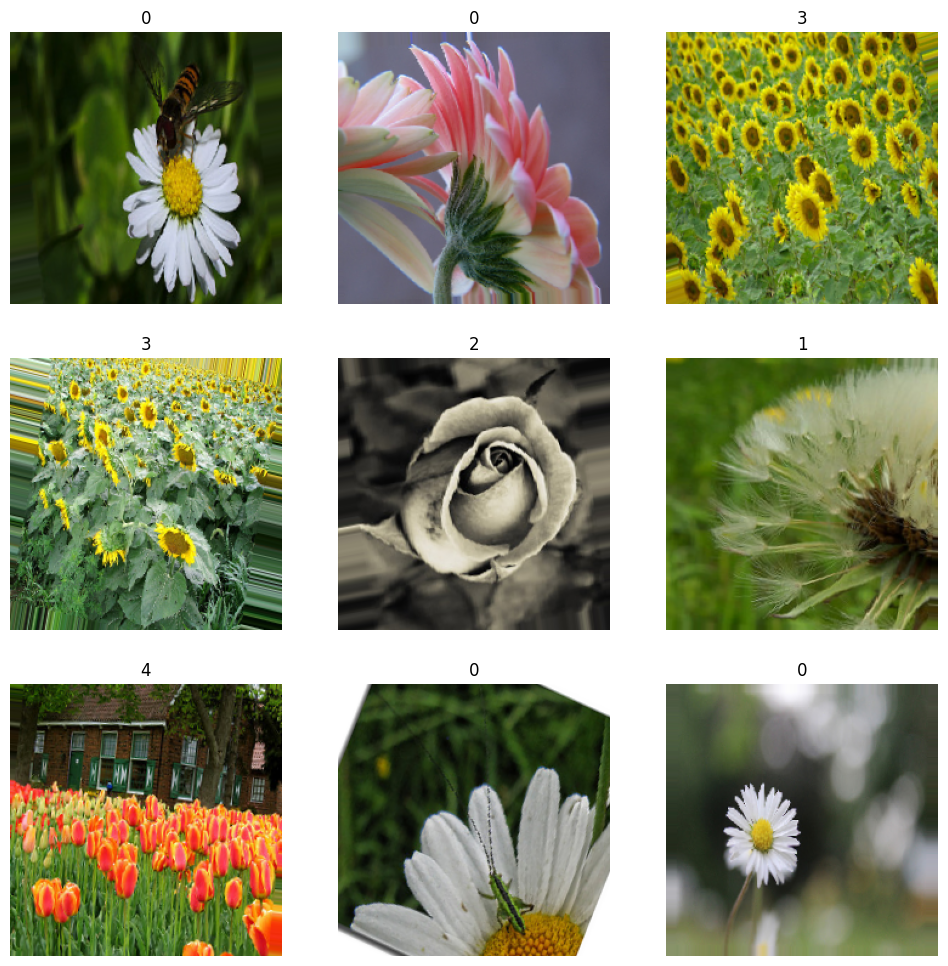

In [5]:
# Plot a batch of images from the training set
images, labels = next(train_generator)

# Display some sample images from the batch
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(np.argmax(labels[i]))  # Show class label
    plt.axis('off')
plt.show()


In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

# Load the VGG16 model with pretrained weights from 'imagenet'
# Set `include_top=False` to remove the final classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model (so we don't retrain the VGG16 part)
base_model.trainable = False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
# Create a new model on top of the VGG16 base
model = models.Sequential()

# Add the VGG16 base model
model.add(base_model)

# Add new custom layers on top of it
model.add(layers.Flatten())  # Flatten the output from the convolutional layers
model.add(layers.Dense(256, activation='relu'))  # Add a fully connected layer with 256 units
model.add(layers.Dropout(0.5))  # Add dropout to prevent overfitting
model.add(layers.Dense(5, activation='softmax'))  # Output layer with 5 units (one for each flower class)


In [8]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',  # Suitable for multiclass classification
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Adam optimizer with a small learning rate
    metrics=['accuracy']  # We will track accuracy during training
)


In [9]:
# Train the model
history = model.fit(
    train_generator,            # Training data
    validation_data=validation_generator,  # Validation data
    epochs=10,                  # Number of epochs (you can increase this if needed)
    steps_per_epoch=train_generator.samples // BATCH_SIZE,  # Number of training steps per epoch
    validation_steps=validation_generator.samples // BATCH_SIZE  # Validation steps per epoch
)


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


108/108 ━━━━━━━━━━━━━━━━━━━━ 1231s 11s/step - accuracy: 0.4678 - loss: 1.3451 - val_accuracy: 0.7067 - val_loss: 0.7632
Epoch 2/10
  1/108 ━━━━━━━━━━━━━━━━━━━━ 15:44 9s/step - accuracy: 0.6250 - loss: 0.8884

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 140ms/step - accuracy: 0.6250 - loss: 0.8884 - val_accuracy: 0.6429 - val_loss: 0.8906
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1230s 11s/step - accuracy: 0.7276 - loss: 0.7709 - val_accuracy: 0.7656 - val_loss: 0.6457
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - accuracy: 0.6875 - loss: 0.6677 - val_accuracy: 0.7857 - val_loss: 0.6709
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1229s 11s/step - accuracy: 0.7632 - loss: 0.6702 - val_accuracy: 0.7596 - val_loss: 0.6583
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - accuracy: 0.8125 - loss: 0.6130 - val_accuracy: 0.7143 - val_loss: 0.5674
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1228s 11s/step - accuracy: 0.7856 - loss: 0.6227 - val_accuracy: 0.7837 - val_loss: 0.5659
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step - accuracy: 0.6250 - loss: 0.8728 - val_accuracy: 0.8214 - val_loss: 0.5952
Epoch 9/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1268s 11s/step - accuracy: 0.7817 - loss: 0.5964 - val_ac

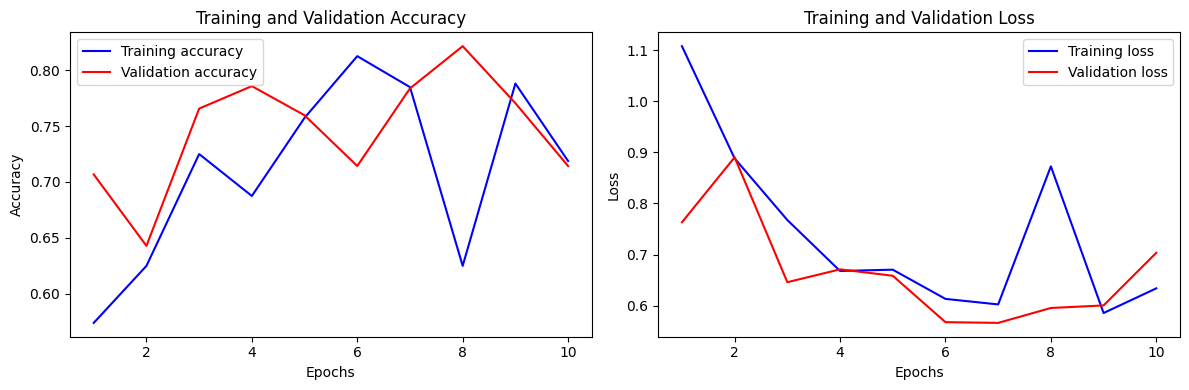

In [10]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [11]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to load and preprocess the image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Change target size to (224, 224)
    img_array = image.img_to_array(img) / 255.0  # Normalize to [0, 1] range
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Path to the custom flower image
img_path = '/kaggle/input/tulipflowers/download.jpg'  # Replace with your image path

# Load and preprocess the image
preprocessed_image = load_and_preprocess_image(img_path)

# Make a prediction
predictions = model.predict(preprocessed_image)

# Get the predicted class index
predicted_class_index = np.argmax(predictions, axis=1)

# Assuming you have a mapping of class indices to class names
class_names = ['dandelion', 'daisy', 'rose', 'sunflower', 'tulip']  # Update with your actual class names
predicted_class = class_names[predicted_class_index[0]]

print(f'The model predicts this flower is a: {predicted_class}')



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
The model predicts this flower is a: dandelion
